# Model training and predictions 
### Read from file and data cleaning

In [1]:
from pyspark.sql import SparkSession
spark  = SparkSession.builder.appName('App').getOrCreate()

In [2]:
# File location and type
file_location = "sample_train3.csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
multiline = "true"
escape = "\""

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.csv(file_location,
                  inferSchema = infer_schema, 
                  sep = delimiter, 
                  header = first_row_is_header, 
                  multiLine = multiline, 
                  escape = escape)

### Indexing tags in both test and train data sets

In [3]:
from pyspark.ml.feature import StringIndexer

#Encode tag's using String indexer

tag_idx = StringIndexer(inputCol='tag', outputCol = 'tag_idx')
tag_encode = tag_idx.fit(df)
df = tag_encode.transform(df)

In [3]:
df.count()

99948

### Preprocessing

In [2]:
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_en = stopwords.words('english')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import RegexTokenizer

""" Helper functions for preprocessing. 
"""

@udf("String")
def lazy_prep_udf(c):
  """
  Clean noises from the string of text in given column

  Args:
    c - Column containing string of text

  Returns:
    Column with the cleaned string of text
  """
  df = BeautifulSoup(c)
  
  #noise
  urls = df.find_all('a')
  if urls != None:
    if len(urls)>0: 
      df.a.clear()
  
  return df.get_text().lower()


def tokenize(df, inputCol, outputCol):
  """
Split string of text in dataframe to word tokens.

Args:
  @param df Dataframe containing string of text
  @param inputCol name of input column containin the string of texts
  @param outputCol name of output column containin the word tokens
  
Returns:
  Dataframe containing the output column and the input column is dropped
"""
  tokenizer = RegexTokenizer(inputCol = inputCol, outputCol = outputCol, pattern=r"\s+") 
  df = tokenizer.transform(df).drop(inputCol)
  return df


def remove_punc(text):
  """Removes all punctuation marks from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String.sql.Row: text w.o punctuation 
  """
  mod_punc = '!"$%&\'()*,-./:;<=>?@[\\]^_`{|}~'
  text = text.translate(str.maketrans(' ', ' ', mod_punc))
  return text.strip()


def remove_num(text):
  """Removes all numbers from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String: text w.o numbers 
  """
  numbers="0123456789"
  text = text.translate(str.maketrans(' ', ' ', numbers))
  return text.strip()


from nltk.tokenize import RegexpTokenizer 

@udf("String")
def trad_prep_udf(body):
  """Traditional body text preprocessing pieline. 
  Args: 
    text (pyspark.sql.Row): Text String to process
  Returns: 
    pyspark.sql.Row.ArrayType: cleaned tokens 
  """
  body = BeautifulSoup(body)
  stemmer = PorterStemmer()
  
  #noise
  urls = body.find_all('a')
  if len(urls)>0: 
    body.a.clear()
  
  text = body.get_text()
  
  words = []
  text = text.lower()

  tokenizer = RegexpTokenizer(r'\w+')
#   text = remove_punc(text)
#   text = remove_num(text)
  sents=tokenizer.tokenize(text)
  for sent in sents: 
    for word in nltk.word_tokenize(sent):
      if word in stop_en: continue
      words.append(stemmer.stem(word))
  return " ".join(words)


  """
Combine word tokens from title and body.

Args:
  df1 Dataframe containing Column with lists of stemmed word tokens from title
  inputCol1 name of the column containing lists of stemmed word tokens from title, cannot be same as inputCol2
  df2 Dataframe containing Column with lists of stemmed word tokens from body
  inputCol2 name of the column containing lists of stemmed word tokens from body, cannot be same as inputCol2
  outputCol column name of the ouput column containing the combined list of word tokens from title and body
"""
def combine_tokens(df, inputCol1, inputCol2, outputCol):
  result = df.withColumn(outputCol, concat(col(inputCol1), col(inputCol2)))
  return result

[nltk_data] Downloading package punkt to /Users/tongxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tongxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
class Preprocessing:
  """Preprocessing stackoverflow question by remove html tags and tokenize words"""
  
  def __init__(self, df, titleCol, bodyCol):
    """
    Construct a Proprocessing object with attribute df: df cleans the text string in the given df using either lazy or traditional preprocessing
    """
#     df = df.withColumn("Lazy_Title", lazy_prep_udf( df[titleCol] ) )
#     df = df.withColumn("Lazy_Body", lazy_prep_udf( df[bodyCol] ) )
    df = df.withColumn("Trad_Title", trad_prep_udf( df[titleCol] ) )
    self.df = df.withColumn("Trad_Body", trad_prep_udf( df[bodyCol] ) )

  def get_token(self):
#     self.df = tokenize(self.df, "Lazy_Title", 'Lazy_Title_Tokens')
#     self.df = tokenize(self.df, "Lazy_Body", 'Lazy_Body_Tokens')
    self.df = tokenize(self.df, "Trad_Title", 'Trad_Title_Tokens')
    self.df = tokenize(self.df, "Trad_Body", 'Trad_Body_Tokens')
    return self.df

In [4]:
#Pre-processing the data
preProcessing = Preprocessing(df, "Title", "Body")
df_data = preProcessing.get_token()

In [9]:
from pyspark.sql.functions import desc, col

tag_counts = df.select('tag').groupby('tag').count().sort(desc('count'))
tag_counts.show()

+---------------+-----+
|            tag|count|
+---------------+-----+
|           html| 1783|
|            ios| 1328|
|            css| 1311|
|           ajax| 1299|
|          xcode|  920|
|       database|  813|
|           json|  786|
|          query|  709|
|          forms|  642|
|    cocoa-touch|  638|
|         jquery|  637|
|        asp.net|  637|
|            sql|  625|
|ruby-on-rails-3|  623|
|    performance|  579|
|           ipad|  574|
|         string|  570|
|            xml|  530|
|       winforms|  530|
|          html5|  525|
+---------------+-----+
only showing top 20 rows



In [10]:
from pyspark.sql.functions import col

tag_counts = df.select('tag').groupby('tag').count().sort(col('count'))
tag_counts.show()

+-------------------+-----+
|                tag|count|
+-------------------+-----+
|                get|   74|
|           treeview|   78|
|              click|   79|
|              scope|   80|
|           uibutton|   80|
|         javascript|   80|
|             window|   81|
|            timeout|   81|
|            listbox|   82|
|parallel-processing|   83|
|              split|   84|
|     android-widget|   84|
|              popup|   84|
|network-programming|   85|
|              icons|   86|
|                sed|   87|
|             styles|   87|
|               ios4|   87|
|              uikit|   87|
|           doctrine|   87|
+-------------------+-----+
only showing top 20 rows



In [6]:
body_counts = df_data.select('Trad_Body_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Body_Tokens]).reduceByKey(lambda a,b: a+b).collect()
body_counts.sort(key=lambda tup: -tup[1])

display(body_counts)

[('0', 103599),
 ('use', 99862),
 ('1', 95885),
 ('class', 61897),
 ('new', 61554),
 ('id', 59498),
 ('get', 58705),
 ('name', 57629),
 ('file', 55695),
 ('valu', 53359),
 ('code', 52908),
 ('string', 51677),
 ('2', 50793),
 ('data', 49350),
 ('function', 48581),
 ('like', 48551),
 ('work', 48359),
 ('tri', 46686),
 ('user', 44135),
 ('public', 42407),
 ('return', 40693),
 ('want', 39528),
 ('type', 39358),
 ('error', 39062),
 ('text', 38467),
 ('div', 38261),
 ('java', 37908),
 ('would', 35377),
 ('set', 34773),
 ('creat', 32312),
 ('need', 32039),
 ('3', 31949),
 ('c', 31021),
 ('page', 30995),
 ('int', 30699),
 ('one', 30566),
 ('server', 30074),
 ('php', 29813),
 ('tabl', 29467),
 ('select', 29156),
 ('way', 29101),
 ('object', 28912),
 ('http', 27698),
 ('com', 27193),
 ('problem', 27131),
 ('var', 26772),
 ('imag', 26568),
 ('applic', 26530),
 ('thank', 26515),
 ('method', 26064),
 ('system', 25927),
 ('e', 24853),
 ('html', 24771),
 ('run', 24638),
 ('android', 24560),
 ('null',

In [7]:
title_counts = df_data.select('Trad_Title_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Title_Tokens]).reduceByKey(lambda a,b: a+b).collect()
title_counts.sort(key=lambda tup: -tup[1])

display(title_counts)

[('use', 10186),
 ('c', 5826),
 ('file', 5804),
 ('jqueri', 4865),
 ('get', 4465),
 ('php', 4390),
 ('net', 3989),
 ('data', 3939),
 ('java', 3300),
 ('error', 3292),
 ('valu', 3282),
 ('object', 3261),
 ('javascript', 3156),
 ('work', 3127),
 ('sql', 3091),
 ('server', 3052),
 ('imag', 2860),
 ('window', 2807),
 ('array', 2762),
 ('android', 2754),
 ('creat', 2647),
 ('tabl', 2629),
 ('string', 2622),
 ('page', 2579),
 ('function', 2536),
 ('databas', 2531),
 ('applic', 2521),
 ('asp', 2505),
 ('mysql', 2492),
 ('app', 2438),
 ('class', 2421),
 ('chang', 2283),
 ('form', 2267),
 ('queri', 2191),
 ('html', 2162),
 ('list', 2140),
 ('web', 2133),
 ('set', 2099),
 ('multipl', 2074),
 ('select', 1977),
 ('control', 1971),
 ('code', 1963),
 ('call', 1959),
 ('view', 1947),
 ('way', 1910),
 ('user', 1909),
 ('text', 1890),
 ('load', 1872),
 ('method', 1870),
 ('ajax', 1845),
 ('xml', 1839),
 ('one', 1776),
 ('access', 1740),
 ('differ', 1702),
 ('make', 1680),
 ('rail', 1636),
 ('python', 1

### Split test/train sets

In [5]:
TRAINING_DATA_RATIO = 0.9
RANDOM_SEED = 1234

splits = [TRAINING_DATA_RATIO, 1.0 - TRAINING_DATA_RATIO]
training_data, test_data = df.randomSplit(splits, RANDOM_SEED)

In [12]:
#Pre-processing the data
preProcessing = Preprocessing(test_data, "Title", "Body")
test_data = preProcessing.get_token()
preProcessing = Preprocessing(training_data, "Title", "Body")
training_data = preProcessing.get_token()


In [6]:
print("Number of training set rows: %d" % training_data.count())
print("Number of test set rows: %d" % test_data.count())

Number of training set rows: 89973
Number of test set rows: 9975


In [13]:
df.show()

+---+--------------------+--------------------+------------------+-------+
|_c0|                Body|               Title|               tag|tag_idx|
+---+--------------------+--------------------+------------------+-------+
|  0|<p>I'm trying to ...|Creating a databa...|          database|    5.0|
|  1|<pre><code>FileNa...|How to remove a l...|            c#-4.0|   79.0|
|  2|<p>Greetings,</p>...|Android: Get resp...|             https|  193.0|
|  3|<p>I want to rese...|How to reset Sql ...|   sql-server-2008|   21.0|
|  4|<p>I have been wo...|Issue calling Web...|           service|  226.0|
|  5|<p>In this applic...|Resize a QWidget ...|            resize|  366.0|
|  6|<p>Now this is a ...|Entity Framework ...|entity-framework-4|  220.0|
|  7|<p>I am writing a...|C++ STL's String ...|               stl|  395.0|
|  8|<p>I am trying my...|AWS Capistrano co...|        amazon-ec2|  455.0|
|  9|<p>I execute <cod...|Effect of Frequen...| memory-management|  150.0|
| 10|<p>I have a RSS f...

# Machine Learning Data Preparation

### Feature Engineering

In [14]:
from pyspark.ml.feature import CountVectorizer, IDF, NGram, VectorAssembler, StringIndexer, HashingTF
from pyspark.ml import Pipeline
def feature_engineer():
# # FOR LAZY PRE-PROCESSING
#   lazy_body_vector = CountVectorizer(inputCol = 'Lazy_Body_Tokens', outputCol = 'lazy_body_vector', minDF=0.01 , maxDF=0.85)
#   lazy_title_vector = CountVectorizer(inputCol = 'Lazy_Title_Tokens', outputCol = 'lazy_title_vector', minDF=0.01 , maxDF=0.85)
  
    # FOR TRAD PRE-PROCESSING
    trad_body_vector = CountVectorizer(inputCol = 'Trad_Body_Tokens', outputCol = 'trad_body_vector', minDF=0.01 , maxDF=0.99)
    trad_title_vector = CountVectorizer(inputCol = 'Trad_Title_Tokens', outputCol = 'trad_title_vector', minDF=0.01 , maxDF=0.99)

#   lazy_body_idf = IDF(inputCol='lazy_body_vector', outputCol='lazy_body_idf')
#   lazy_title_idf = IDF(inputCol='lazy_title_vector', outputCol='lazy_title_idf')

#   trad_body_idf = IDF(inputCol='trad_body_vector', outputCol='trad_body_idf')
#   trad_title_idf = IDF(inputCol='trad_body_vector', outputCol='trad_title_idf')



#   lazy_features = VectorAssembler(inputCols=['lazy_body_vector', 'lazy_title_vector'], outputCol='lazy_features')
    trad_features = VectorAssembler(inputCols=['trad_body_vector', 'trad_title_vector'], outputCol='trad_features')
#     pipe = Pipeline(stages=[lazy_body_vector, lazy_title_vector, lazy_features, trad_body_vector, trad_title_vector, trad_features])
    pipe = Pipeline(stages=[trad_body_vector, trad_title_vector, trad_features])
    pipe_model = pipe.fit(training_data)
    train_df = pipe_model.transform(training_data)  
    test_df = pipe_model.transform(test_data)
    return train_df, test_df

In [15]:
training_data = training_data.repartition(8)
test_data = test_data.repartition(8)

In [16]:
train_df, test_df = feature_engineer()
display(test_df.toPandas())

,_c0,Body,Title,tag,tag_idx,Trad_Title_Tokens,Trad_Body_Tokens,trad_body_vector,trad_title_vector,trad_features
0,45769,<p>Ive got problem with adding Expanded event ...,Adding multiple expanders event programmatical...,events,48.0,"[ad, multipl, expand, event, programmat, wont,...","[ive, got, problem, ad, expand, event, expand,...","(3.0, 0.0, 6.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(3.0, 0.0, 6.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, ..."
1,33116,<p>How to check if wifi option is enabled on t...,How To check if wifi option enabled or not,ios,1.0,"[check, wifi, option, enabl]","[check, wifi, option, enabl, iphon, mayb, ipho...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,9528,<p>I am working on an app that has several pro...,IOS create new UITableViewCell with properties...,objective-c,94.0,"[io, creat, new, uitableviewcel, properti, pro...","[work, app, sever, prototyp, cell, one, view, ...","(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,41896,<p>I'm experiencing a problem when parsing a s...,Why does the JSONArray constructor removes som...,string,16.0,"[jsonarray, constructor, remov, string, valu, ...","[experienc, problem, pars, string, jsonarray, ...","(2.0, 0.0, 3.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2.0, 0.0, 3.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, ..."
4,92282,<p>My question is simple. It might be too simp...,Is performing two morphological Dilation with ...,opencv,335.0,"[perform, two, morpholog, dilat, 3x3, structur...","[question, simpl, might, simpl, thing, work, o...","(0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...
9970,4168,"<p>I am facing a weird problem in production, ...",.Net Mail Duplicates,asp.net,10.0,"[net, mail, duplic]","[face, weird, problem, product, happen, local,...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9971,59887,<p>I'm developing an upload form. It works fin...,IE doesn't wait for result of $.post(,post,83.0,"[ie, wait, result, post]","[develop, upload, form, work, fine, firefox, i...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9972,37245,<p>How can I tell Visual Studio 2012 to recogn...,how to set Visual Studio 2012 to use JavaScrip...,visual-studio-2012,431.0,"[set, visual, studio, 2012, use, javascript, e...","[tell, visual, studio, 2012, recogn, classic, ...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
9973,67480,<p>How to make EditText Field uneditable over ...,Make EditText field uneditable,android-layout,358.0,"[make, edittext, field, unedit]","[make, edittext, field, unedit, properti, inpu...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
test_df.write.parquet("test_df_train_3")
train_df.write.parquet("train_df_train_3")

# Model Training

## Logistic Regression

**Hyperparameter Tuning**

In [23]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString


lr = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx")

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0, 0.01, 0.1, 1.0]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

lr_tvs = TrainValidationSplit(estimator=lr, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx', metricName='accuracy'), 
                          trainRatio=0.9, 
                          seed=0
                         )



In [21]:
model = lr_tvs.fit(train_df)

In [22]:
print('Best Param (regParam): ', model.bestModel._java_obj.getRegParam())
print('Best Param (elasticNetParam): ', model.bestModel._java_obj.getElasticNetParam())
print('Best Param (fitIntercept): ', model.bestModel._java_obj.getFitIntercept())

Best Param (regParam):  0.01
Best Param (elasticNetParam):  0.0
Best Param (fitIntercept):  False


**Model training and transformation of test set**

In [ ]:
# Trad model
from pyspark.ml.classification import LogisticRegression

lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0, regParam=0.01)
lr_trad_model = lr_trad.fit(train_df)
lr_trad_results = lr_trad_model.transform(test_df)

**Performance Metrics**

In [19]:
# Trad Metrics
from pyspark.mllib.evaluation import MulticlassMetrics
#Get labels/predictions in RDD expected by metrics classes
lr_trad_labels_and_predictions = lr_trad_results.select(["tag_idx", "prediction"])

# Instantiate metrics object
lr_trad_metrics = MulticlassMetrics(lr_trad_labels_and_predictions.rdd)

# Overall statistics
precision = lr_trad_metrics.precision(1.0)
recall = lr_trad_metrics.recall(1.0)
f1Score = lr_trad_metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Weighted stats
print("Weighted recall = %s" % lr_trad_metrics.weightedRecall)
print("Weighted precision = %s" % lr_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % lr_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % lr_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % lr_trad_metrics.weightedFalsePositiveRate)

Summary Stats
Precision = 0.2805755395683453
Recall = 0.10684931506849316
F1 Score = 0.15476190476190477
Weighted recall = 0.17533834586466138
Weighted precision = 0.2900151530167615
Weighted F(1) Score = 0.20224616277784171
Weighted F(0.5) Score = 0.24176594334583226
Weighted false positive rate = 0.003447238923783803


## Random Forest

**Hyperparameter Tuning**

In [4]:
test_df = spark.read.parquet("test_df_train")
test_df = test_df.repartition(8)
train_df = spark.read.parquet("train_df_train")
train_df = train_df.repartition(8)

In [2]:
#Random Forest Classification
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx")

paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [5,10,15]) \
    .addGrid(rf.maxDepth, [5,10,15])\
    .build()

rf_tvs = TrainValidationSplit(estimator=rf, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx'), 
                          trainRatio=0.9
                         )

In [3]:
model = rf_tvs.fit(train_df)
model.bestModel
print('Best Param (numTrees): ', model.bestModel._java_obj.getNumTrees())
print('Best Param (maxDepth): ', model.bestModel._java_obj.getMaxDepth())

Best Param (numTrees):  15
Best Param (maxDepth):  15


**Model training and transformation of test set**

In [20]:
# Trad Model
from pyspark.ml.classification import RandomForestClassifier

rf_trad = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx", maxDepth=15, numTrees=15)
rf_trad_model = rf_trad.fit(train_df)
rf_trad_result = rf_trad_model.transform(test_df)

**Performance Metrics**

In [21]:
# Trad Metrics (maxDepth x numTrees: 15 x 15)
from pyspark.mllib.evaluation import MulticlassMetrics

#Get labels/predictions in RDD expected by metrics classes
rf_trad_labels_and_predictions = rf_trad_result.select(["tag_idx", "prediction"])

# Instantiate metrics object
rf_trad_metrics = MulticlassMetrics(rf_trad_labels_and_predictions.rdd)

# Overall statistics
precision = rf_trad_metrics.precision(1.0)
recall = rf_trad_metrics.recall(1.0)
f1Score = rf_trad_metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Weighted stats
print("Weighted recall = %s" % rf_trad_metrics.weightedRecall)
print("Weighted precision = %s" % rf_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % rf_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % rf_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % rf_trad_metrics.weightedFalsePositiveRate)

Summary Stats
Precision = 0.7482014388489209
Recall = 0.03506405933917734
F1 Score = 0.06698872785829307
Weighted recall = 0.11418546365914789
Weighted precision = 0.4900653867728236
Weighted F(1) Score = 0.1558239034118755
Weighted F(0.5) Score = 0.22906771332167253
Weighted false positive rate = 0.004392713811893359


In [2]:
# Trad Model
from pyspark.ml.classification import RandomForestClassifier

rf_trad = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx", maxDepth=15, numTrees=20)
rf_trad_model = rf_trad.fit(train_df)
rf_trad_result = rf_trad_model.transform(test_df)

In [3]:
# Trad Metrics (maxDepth x numTrees: 15 x 20)
from pyspark.mllib.evaluation import MulticlassMetrics

#Get labels/predictions in RDD expected by metrics classes
rf_trad_labels_and_predictions = rf_trad_result.select(["tag_idx", "prediction"])

# Instantiate metrics object
rf_trad_metrics = MulticlassMetrics(rf_trad_labels_and_predictions.rdd)

# Overall statistics
precision = rf_trad_metrics.precision(1.0)
recall = rf_trad_metrics.recall(1.0)
f1Score = rf_trad_metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Weighted stats
print("Weighted recall = %s" % rf_trad_metrics.weightedRecall)
print("Weighted precision = %s" % rf_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % rf_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % rf_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % rf_trad_metrics.weightedFalsePositiveRate)

Summary Stats
Precision = 0.7122302158273381
Recall = 0.037162162162162164
F1 Score = 0.07063860149839458
Weighted recall = 0.11789473684210529
Weighted precision = 0.48540473628882597
Weighted F(1) Score = 0.1597831475302337
Weighted F(0.5) Score = 0.23555354305057402
Weighted false positive rate = 0.004571747983324777


##SVC + OVR
Due to limited nodes included in the databricks community edition, we were unable to fit a one-vs-rest model with a support-vector-classifier in under 3 hours. Therefore, we recommend future researchers consider investing is a full fledged account to test this model type on large datasets.

# Results Analysis
As we can see from the above, the __ and __ model performed best on the lazy features and traditional features, respectively. We will now use the __ model to determine the highest performing and lowest performing classes.

In [3]:
top_df = lr_trad_results
display(top_df.toPandas()) 

,_c0,Body,Title,tag,tag_idx,Trad_Title_Tokens,Trad_Body_Tokens,trad_body_vector,trad_title_vector,trad_features,rawPrediction,probability,prediction
0,38847,<p>We have been working on a project for sever...,Intermittent 500 errors from Apache running Ze...,zend-framework,292.0,"[intermitt, 500, error, apach, run, zend, fram...","[work, project, sever, month, without, problem...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[-0.6706693013380934, -0.4097691057378655, -0....","[0.0005721915448589261, 0.0007427607589719639,...",154.0
1,98185,<p>I'm subscribing to a WMI event and receivin...,"WMI Exception: ""COM object that has been separ...",com,306.0,"[wmi, except, com, object, separ, underli, rcw...","[subscrib, wmi, event, receiv, com, object, se...","(1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.201176678971778, 0.9864315632032647, -0.466...","[0.0022161574194251954, 0.00485995747677922, 0...",52.0
2,63406,<p>Windows XP this batch file/text file method...,Windows Batch File,batch-file,475.0,"[window, batch, file]","[window, batch, file, text, file, method, auto...","(0.0, 0.0, 0.0, 3.0, 0.0, 6.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 3.0, 0.0, 6.0, 0.0, 0.0, 0.0, ...","[0.5988520905432003, 0.6372789676029622, 0.406...","[0.0030694769992877452, 0.0031897229567388516,...",49.0
3,67753,<p>I have a slideshow of pictures that I am tr...,align wordpress slideshow in center,wordpress,91.0,"[align, wordpress, slideshow, center]","[slideshow, pictur, tri, center, align, right,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2840500553275778, 0.3142412098576164, 0.421...","[0.0026386869982705234, 0.0027195667888801002,...",152.0
4,1732,<p>How can I easily make my own jQuery accordi...,How can I easily make my own jQuery accordion?,jquery-ui,30.0,"[easili, make, jqueri, accordion]","[easili, make, jqueri, accordion, like, avoid,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.131173982043978, -0.1337377279400549, 2.224...","[0.01529292287299421, 0.001588004908922329, 0....",30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9970,93804,<p>In process to integrate my Console based ap...,Need to Display Data From SQL in a Multiline T...,sql,12.0,"[need, display, data, sql, multilin, textbox]","[process, integr, consol, base, applic, web, b...","(2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, ...","[1.4845178584240648, 0.9535706915872153, 1.456...","[0.0073245690745887704, 0.004307196192005606, ...",12.0
9971,54281,<p>i have a Class like</p>\n\n<pre><code>publi...,Calculation in List with Duplications,winforms,17.0,"[calcul, list, duplic]","[class, like, public, class, user, public, int...","(0.0, 2.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6915120984095928, 1.2468386136435559, 0.332...","[0.0034579410984571977, 0.006025496417549045, ...",51.0
9972,60548,<p>I have a correctly formatted RequestSecurit...,How do I redirect my RequestSecurityTokenRespo...,azure,432.0,"[redirect, requestsecuritytokenrespons, anoth,...","[correctli, format, requestsecuritytokenrespon...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6874708505481797, 0.10112171953180801, 0.16...","[0.0038102305661233235, 0.0021198399113830733,...",95.0


In [4]:
top_df.write.parquet("top_df_train_3")

In [1]:
top_df = spark.read.parquet("top_df_train_3")
top_df = top_df.repartition(8)
train_df = spark.read.parquet("train_df_train_3")
train_df = train_df.repartition(8)

In [4]:
from pyspark.ml.feature import IndexToString
from pyspark.sql import functions as F

decoder = IndexToString(inputCol="prediction", outputCol="predicted_tag", labels=tag_encode.labels)
top_df = decoder.transform(top_df)

In [5]:
top_df.select(["tag", "tag_idx", "prediction", "predicted_tag"]).show()

+----------------+-------+----------+--------------+
|             tag|tag_idx|prediction| predicted_tag|
+----------------+-------+----------+--------------+
|        database|    5.0|      24.0|         image|
|          select|   96.0|      22.0|          linq|
|            iis7|  225.0|      99.0|           mvc|
|      properties|  194.0|     194.0|    properties|
|             div|   64.0|      64.0|           div|
|             div|   64.0|      64.0|           div|
|             sql|   12.0|       5.0|      database|
|             sql|   12.0|       5.0|      database|
|       ms-access|  216.0|     216.0|     ms-access|
|           table|   47.0|       7.0|         query|
|      python-2.7|  428.0|      52.0|        object|
|       variables|   57.0|     332.0|error-handling|
|         onclick|  476.0|      57.0|     variables|
|            menu|  261.0|      10.0|       asp.net|
|          filter|  337.0|      86.0|     core-data|
|entity-framework|   34.0|     473.0|         

In [6]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
from pyspark.sql.functions import desc, col
def get_label_metrics(results_df, ground_truth_col='tag_idx', prediction_col='prediction'):
    """Get pandas dataframe of top 10 tags with metrics from top_df
    Params: 
        results_df (pyspark DataFrame): top_df to get metrics of
    Returns:
        (pd.DataFrame): pandas dataframe in form of {column: [row_data]} for plotting
    """
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)
    #get dict of labels to plot
    label_metrics = {}
    # Statistics by class
    labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
    # print(labels)
    for label in sorted(labels):
        prec_recall_fMeasure = ()
        try:
            prec = metrics.precision(label)
            recall = metrics.recall(label)
            fMeasure = metrics.fMeasure(label, beta=1.0)
            prec_recall_fMeasure = (fMeasure, prec, recall) 
            label_metrics[label] = prec_recall_fMeasure
        except: 
            label_metrics[label] = (0,0,0)
    # get tags in string form: 
    tags = results_df.select(['tag', 'tag_idx']).distinct().collect()
    tag_pairs = {x['tag_idx']: x['tag'] for x in tags}
    # Convert tag classes into strings 
    tag_metrics = {}
    for tag_index in tag_pairs: 
        tag_metrics[tag_pairs[tag_index]] = label_metrics[tag_index]
    # Top 10 tags
    top_10_tags = sorted(tag_metrics, key=lambda x: tag_metrics[x][0], reverse=True)
    # Get overall tag counts from input DF
    tag_counts = train_df.select('tag').groupby('tag').count().sort(desc('count')).collect()
    tag_counts = {x['tag']: x['count'] for x in tag_counts}
    # Get ready for plotting
    plot_dict = {}
    tag_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    tag_count_list = []
    for tag in top_10_tags:
        tag_list.append(tag)
        f1_list.append(tag_metrics[tag][0])
        precision_list.append(tag_metrics[tag][1])
        recall_list.append(tag_metrics[tag][2])
        tag_count_list.append(tag_counts[tag])
    plot_df = pd.DataFrame({"Tag": tag_list, "F1Measure": f1_list, "Precision":precision_list, "Recall":recall_list, "Count":tag_count_list})
    return plot_df

In [7]:
plot_df = get_label_metrics(top_df)
print(plot_df)

                Tag  F1Measure  Precision    Recall  Count
0            widget   0.545455   0.500000  0.600000     89
1            jtable   0.526316   0.454545  0.625000    105
2         core-data   0.491803   0.600000  0.416667    242
3            random   0.466667   0.466667  0.466667    146
4          printing   0.451613   0.318182  0.777778    169
..              ...        ...        ...       ...    ...
495    installation   0.000000   0.000000  0.000000    111
496           jsf-2   0.000000   0.000000  0.000000     81
497  eclipse-plugin   0.000000   0.000000  0.000000     93
498       datatable   0.000000   0.000000  0.000000    122
499            ios4   0.000000   0.000000  0.000000     79

[500 rows x 5 columns]


In [19]:
bottom_10 = plot_df.sort_values("Count").head(10)
print(bottom_10)

            Tag  F1Measure  Precision  Recall  Count
377         get   0.000000   0.000000     0.0     60
421       click   0.000000   0.000000     0.0     66
383    treeview   0.000000   0.000000     0.0     68
316      window   0.000000   0.000000     0.0     70
356  javascript   0.000000   0.000000     0.0     70
405    doctrine   0.000000   0.000000     0.0     73
485     timeout   0.000000   0.000000     0.0     73
430    uibutton   0.000000   0.000000     0.0     73
397       scope   0.000000   0.000000     0.0     74
59        icons   0.285714   0.272727     0.3     75


<ipython-input-11-3f950867066e>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


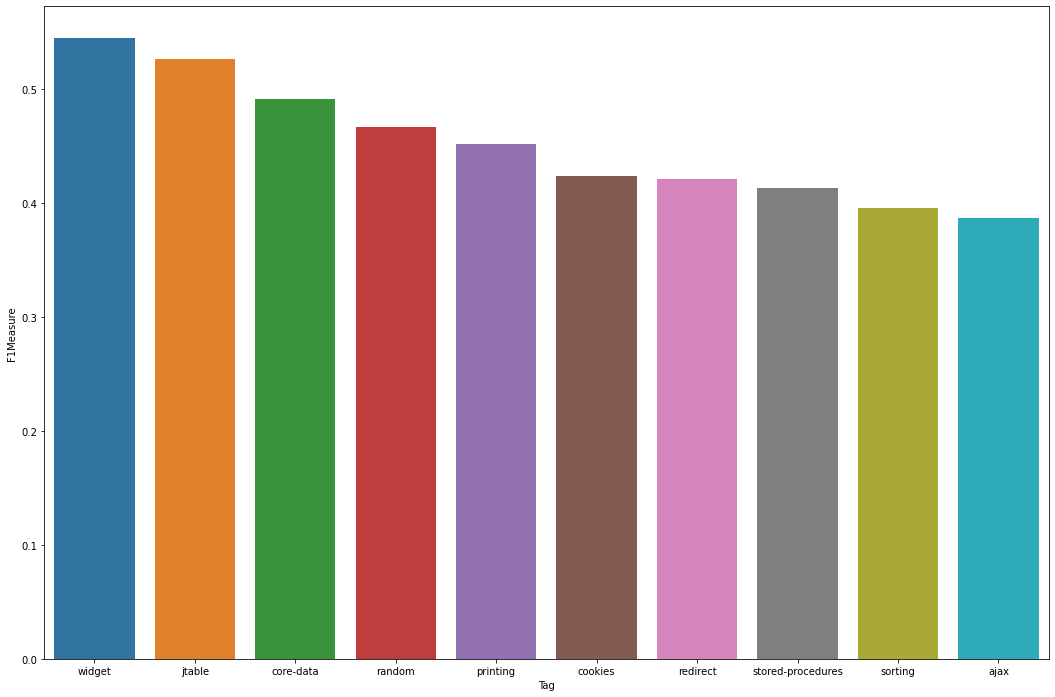

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="F1Measure", data=plot_df[:10], ax=ax)
fig.show()

plt.savefig("Tag3_top10_f1_train")

<ipython-input-10-d02f0d6cba24>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


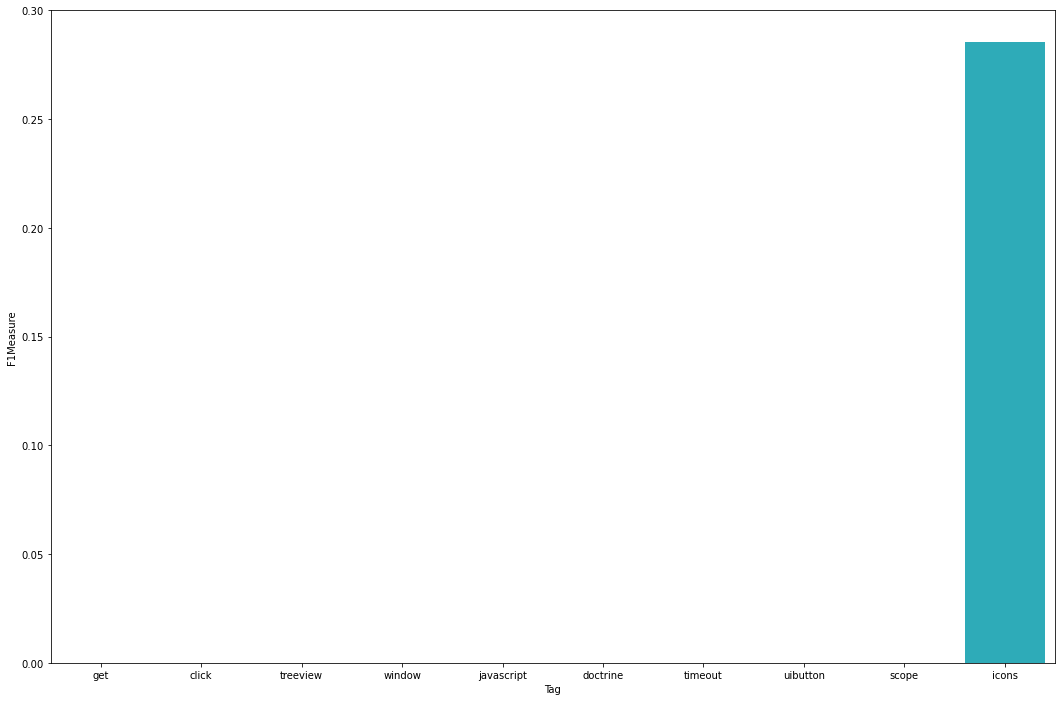

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="F1Measure", data=bottom_10, ax=ax)
fig.show()
plt.savefig("Tag3_bottom10_f1_train")

<ipython-input-13-5973dbfb5d86>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


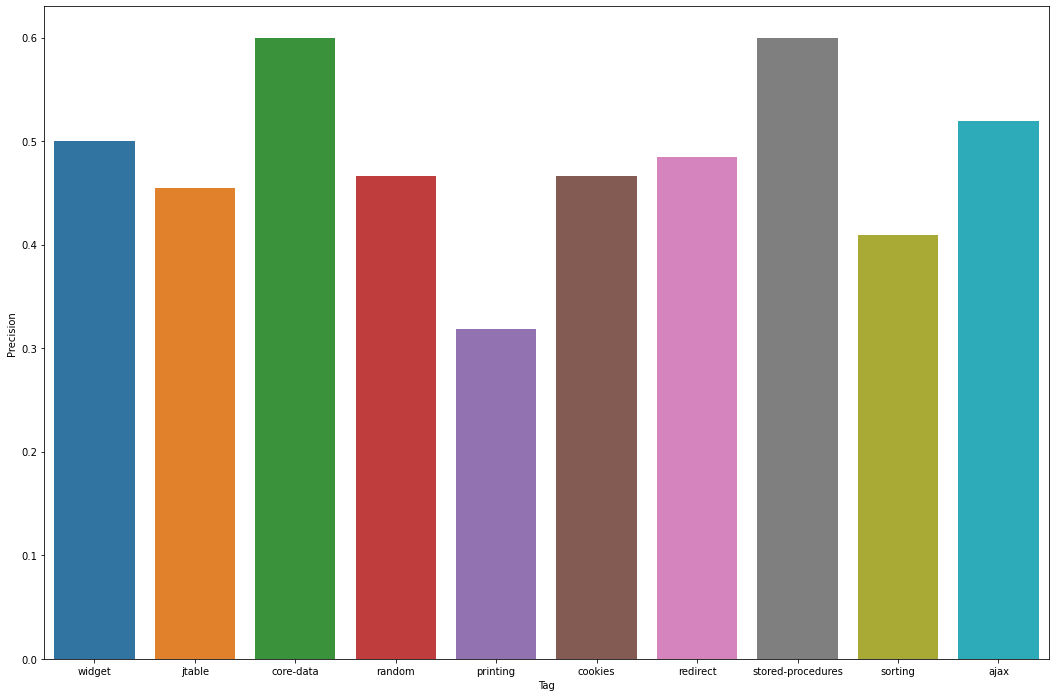

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Precision", data=plot_df[:10], ax=ax)
fig.show()
plt.savefig("Tag3_top10_prec_train")

<ipython-input-14-80cc1e51056a>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


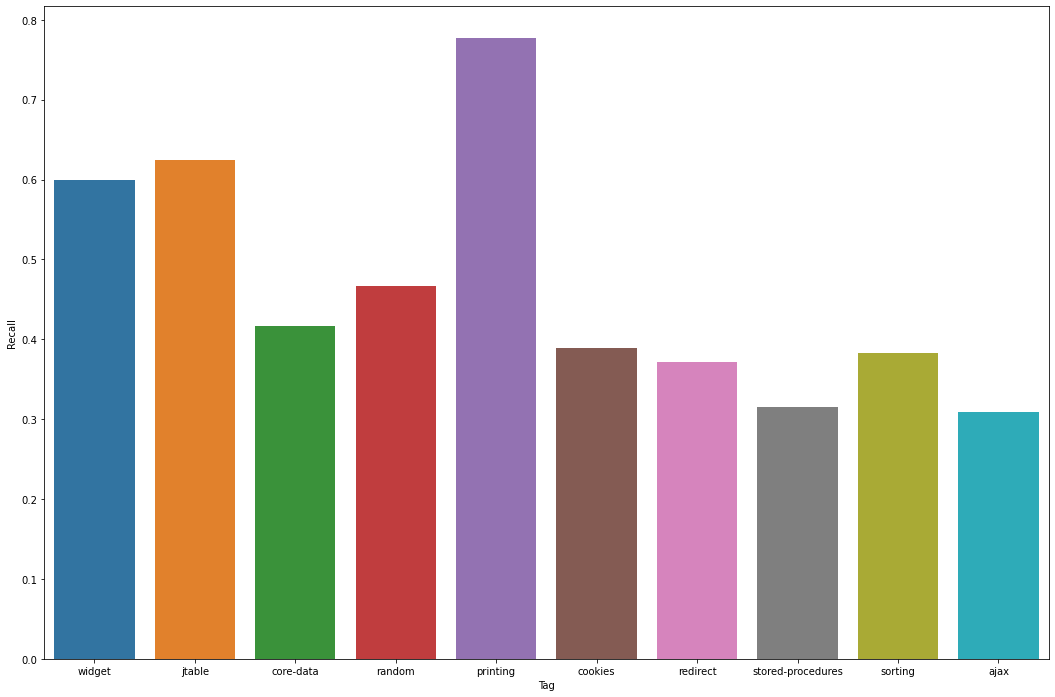

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Recall", data=plot_df[:10], ax=ax)
fig.show()
plt.savefig("Tag3_top10_recall_train")

<ipython-input-15-6a13e456b5be>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


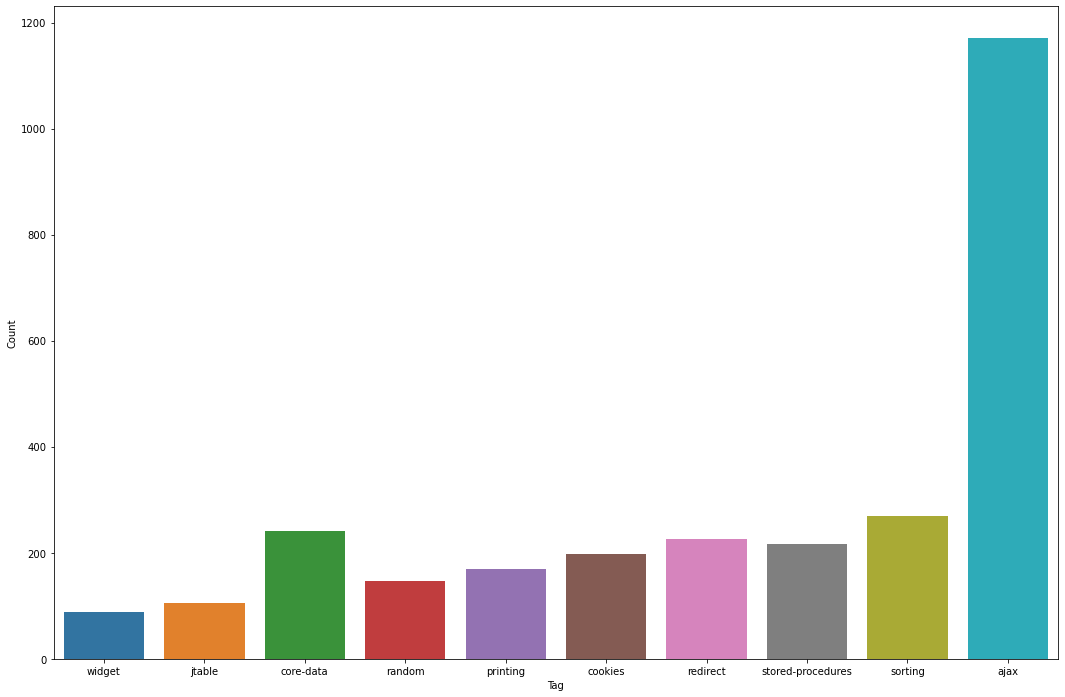

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Count", data=plot_df[:10], ax=ax)
fig.show()
plt.savefig("Tag3_top10_count_train")

<ipython-input-16-0d5ac2826209>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


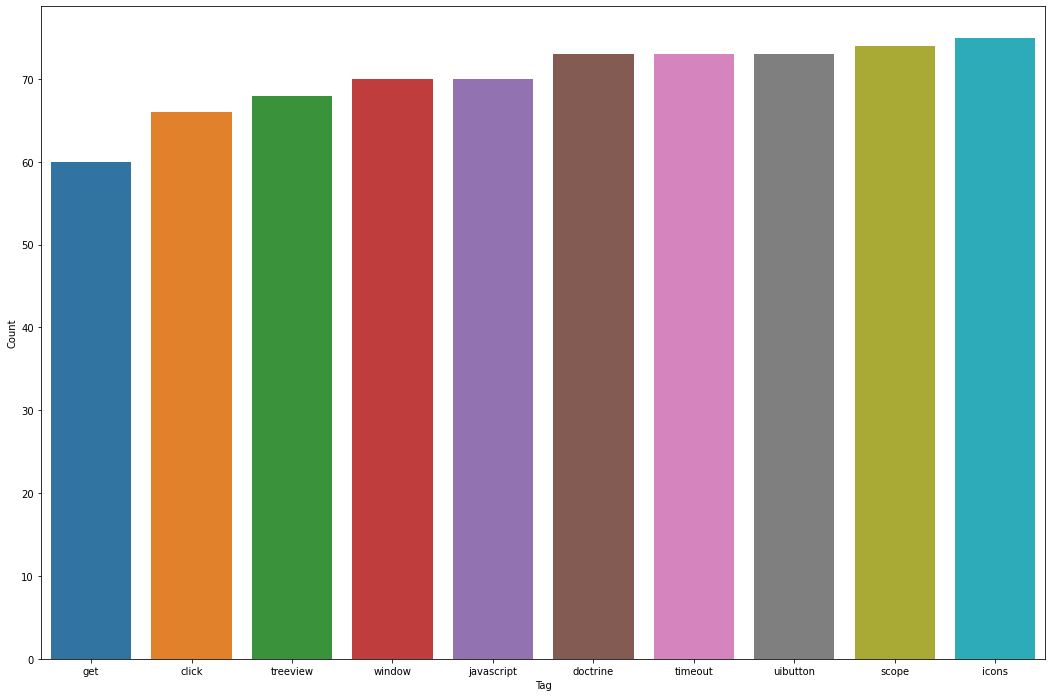

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Count", data=bottom_10, ax=ax)
fig.show()
plt.savefig("Tag3_bottom10_count_train")

<ipython-input-17-3e38adbf9533>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


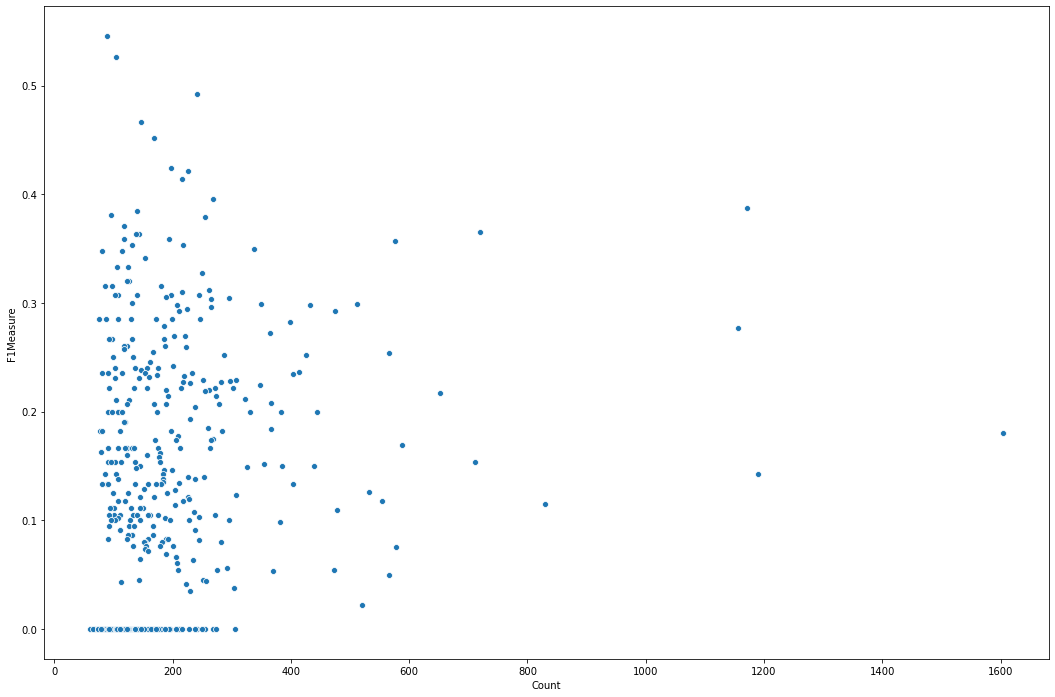

In [17]:
# Counts vs F1

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.scatterplot(x="Count", y="F1Measure", data=plot_df, ax=ax)
fig.show()
plt.savefig("Tag 3 F1Measure vs Count train")

In [11]:
from pyspark.mllib.evaluation import MulticlassMetrics

#Get labels/predictions in RDD expected by metrics classes
labels_and_predictions = top_df.select(["tag_idx", "prediction"])

# Instantiate metrics object
metrics = MulticlassMetrics(labels_and_predictions.rdd)

# Overall statistics
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

# Statistics by class
labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
for label in sorted(labels):
    try:
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    except: 
        print("Class %s not in this set!" % (label))

Summary Stats
Precision = 0.2589928057553957
Recall = 0.0989010989010989
F1 Score = 0.14314115308151093
Weighted recall = 0.17112781954887196
Weighted precision = 0.2898152633661044
Weighted F(1) Score = 0.19953970720517958
Weighted F(0.5) Score = 0.2401692662080218
Weighted false positive rate = 0.003473729909099754
Class 0.0 precision = 0.329608938547486
Class 0.0 recall = 0.12447257383966245
Class 0.0 F1 Measure = 0.18070444104134764
Class 1.0 precision = 0.2589928057553957
Class 1.0 recall = 0.0989010989010989
Class 1.0 F1 Measure = 0.14314115308151093
Class 2.0 precision = 0.38064516129032255
Class 2.0 recall = 0.2177121771217712
Class 2.0 F1 Measure = 0.27699530516431925
Class 3.0 precision = 0.5196850393700787
Class 3.0 recall = 0.308411214953271
Class 3.0 F1 Measure = 0.3870967741935484
Class 4.0 precision = 0.14444444444444443
Class 4.0 recall = 0.0962962962962963
Class 4.0 F1 Measure = 0.11555555555555555
Class 5.0 precision = 0.21782178217821782
Class 5.0 recall = 0.11827956

Class 302.0 not in this set!
Class 303.0 not in this set!
Class 304.0 precision = 0.4666666666666667
Class 304.0 recall = 0.2916666666666667
Class 304.0 F1 Measure = 0.35897435897435903
Class 305.0 not in this set!
Class 306.0 not in this set!
Class 307.0 precision = 0.0
Class 307.0 recall = 0.0
Class 307.0 F1 Measure = 0.0
Class 308.0 precision = 0.0
Class 308.0 recall = 0.0
Class 308.0 F1 Measure = 0.0
Class 309.0 precision = 0.0
Class 309.0 recall = 0.0
Class 309.0 F1 Measure = 0.0
Class 310.0 precision = 0.0
Class 310.0 recall = 0.0
Class 310.0 F1 Measure = 0.0
Class 311.0 precision = 0.3
Class 311.0 recall = 0.15789473684210525
Class 311.0 F1 Measure = 0.20689655172413793
Class 312.0 precision = 0.0
Class 312.0 recall = 0.0
Class 312.0 F1 Measure = 0.0
Class 313.0 precision = 0.18181818181818182
Class 313.0 recall = 0.2
Class 313.0 F1 Measure = 0.1904761904761905
Class 314.0 precision = 0.0
Class 314.0 recall = 0.0
Class 314.0 F1 Measure = 0.0
Class 315.0 precision = 0.0
Class 315

Class 463.0 not in this set!
Class 464.0 precision = 0.0
Class 464.0 recall = 0.0
Class 464.0 F1 Measure = 0.0
Class 465.0 not in this set!
Class 466.0 not in this set!
Class 467.0 precision = 0.08333333333333333
Class 467.0 recall = 0.3333333333333333
Class 467.0 F1 Measure = 0.13333333333333333
Class 468.0 precision = 0.0
Class 468.0 recall = 0.0
Class 468.0 F1 Measure = 0.0
Class 469.0 precision = 0.0
Class 469.0 recall = 0.0
Class 469.0 F1 Measure = 0.0
Class 470.0 not in this set!
Class 471.0 precision = 0.0
Class 471.0 recall = 0.0
Class 471.0 F1 Measure = 0.0
Class 472.0 not in this set!
Class 473.0 precision = 0.3333333333333333
Class 473.0 recall = 0.10810810810810811
Class 473.0 F1 Measure = 0.163265306122449
Class 474.0 precision = 0.1
Class 474.0 recall = 1.0
Class 474.0 F1 Measure = 0.18181818181818182
Class 475.0 not in this set!
Class 476.0 not in this set!
Class 477.0 precision = 0.25
Class 477.0 recall = 0.2222222222222222
Class 477.0 F1 Measure = 0.23529411764705882
C

In [12]:
top_df = top_df.withColumn("correct", top_df.prediction==top_df.tag_idx)
tag_corrects = top_df.groupby('tag').agg(F.sum(F.col("correct").cast("long"))).withColumnRenamed("sum(CAST(correct AS BIGINT))", "correct_sum")
tag_counts = top_df.groupBy("tag").count()
correct_tags = tag_corrects.join(tag_counts, on='tag')
correct_tags.show()

+-------------------+-----------+-----+
|                tag|correct_sum|count|
+-------------------+-----------+-----+
|             iframe|          2|   18|
|              input|          1|   17|
|             import|          1|    9|
|            include|          1|    8|
|            routing|          1|   11|
|     android-widget|          0|    9|
|             charts|          0|   15|
|           doctrine|          0|   14|
|           gridview|          4|   30|
|           keyboard|          0|   18|
|                map|          0|   15|
|                 qt|          0|   12|
|                jar|          0|    7|
|network-programming|          0|    9|
|              boost|          1|   15|
|                rss|          0|   13|
|         phpmyadmin|          0|   13|
|            session|          4|   29|
|     drop-down-menu|          0|   14|
|   image-processing|          1|   13|
+-------------------+-----------+-----+
only showing top 20 rows



In [13]:
from pyspark.sql.functions import col

correct_tags.sort(col('correct_sum').desc()).show()

+-----------------+-----------+-----+
|              tag|correct_sum|count|
+-----------------+-----------+-----+
|             ajax|         66|  127|
|              css|         59|  155|
|             html|         59|  179|
|              ios|         36|  139|
|             json|         34|   67|
|            forms|         33|   66|
|           string|         32|   59|
|            query|         25|   57|
|              xml|         25|   55|
|            image|         25|   45|
|  ruby-on-rails-3|         24|   57|
|           arrays|         23|   57|
|         database|         22|  101|
|        variables|         19|   39|
|        jquery-ui|         18|   54|
|stored-procedures|         18|   30|
|       validation|         18|   28|
|          sorting|         18|   44|
|             linq|         17|   48|
|             list|         17|   32|
+-----------------+-----------+-----+
only showing top 20 rows



In [14]:
correct_tags = correct_tags.withColumn("accuracy", F.col("correct_sum") / F.col("count"))
correct_tags.orderBy("accuracy", ascending=False).show()

+-----------------+-----------+-----+-------------------+
|              tag|correct_sum|count|           accuracy|
+-----------------+-----------+-----+-------------------+
|       validation|         18|   28| 0.6428571428571429|
|stored-procedures|         18|   30|                0.6|
|        core-data|         15|   25|                0.6|
|             time|         12|   20|                0.6|
|           google|         12|   21| 0.5714285714285714|
|            image|         25|   45| 0.5555555555555556|
|           string|         32|   59| 0.5423728813559322|
|             list|         17|   32|            0.53125|
|             ajax|         66|  127| 0.5196850393700787|
|             json|         34|   67| 0.5074626865671642|
|             post|         12|   24|                0.5|
|            video|          6|   12|                0.5|
|            forms|         33|   66|                0.5|
|           widget|          3|    6|                0.5|
|        varia

In [17]:
correct_tags.write.parquet("correct_tags_train_3")

In [18]:
top_10_accuracy = correct_tags.orderBy("accuracy", ascending=False).limit(10).toPandas()
top_10_count = correct_tags.orderBy("count", ascending=False).limit(10).toPandas()
top_10_correct = correct_tags.orderBy("correct_sum", ascending=False).limit(10).toPandas()

<ipython-input-19-c997699e9815>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


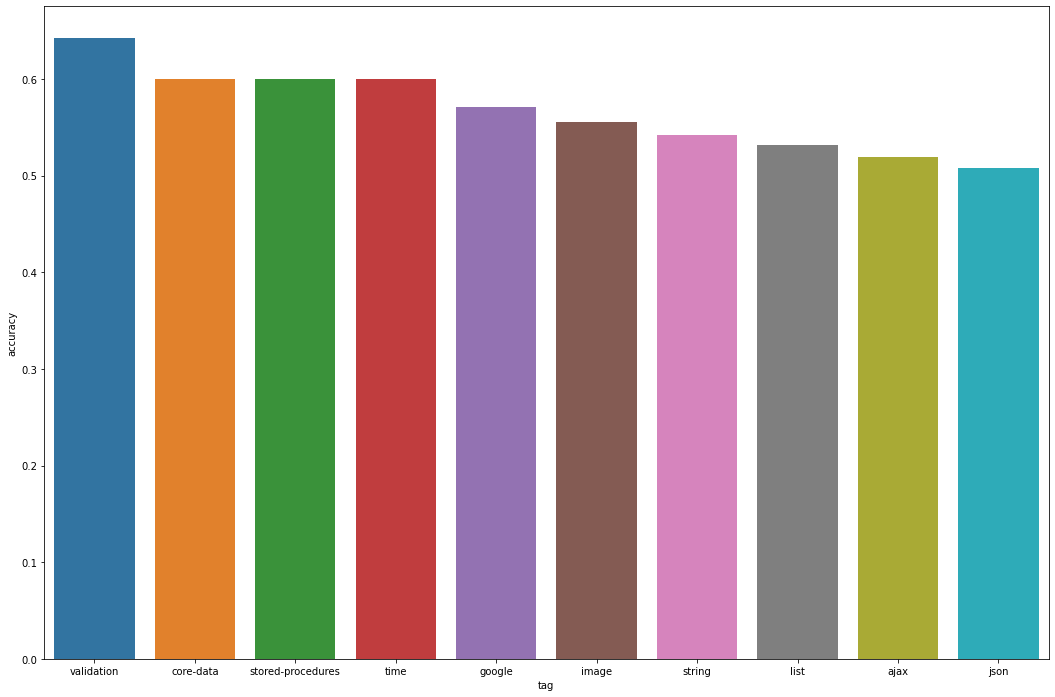

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="tag", y="accuracy", data=top_10_accuracy, ax =ax)
fig.show()

<ipython-input-20-98240cbc50d0>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


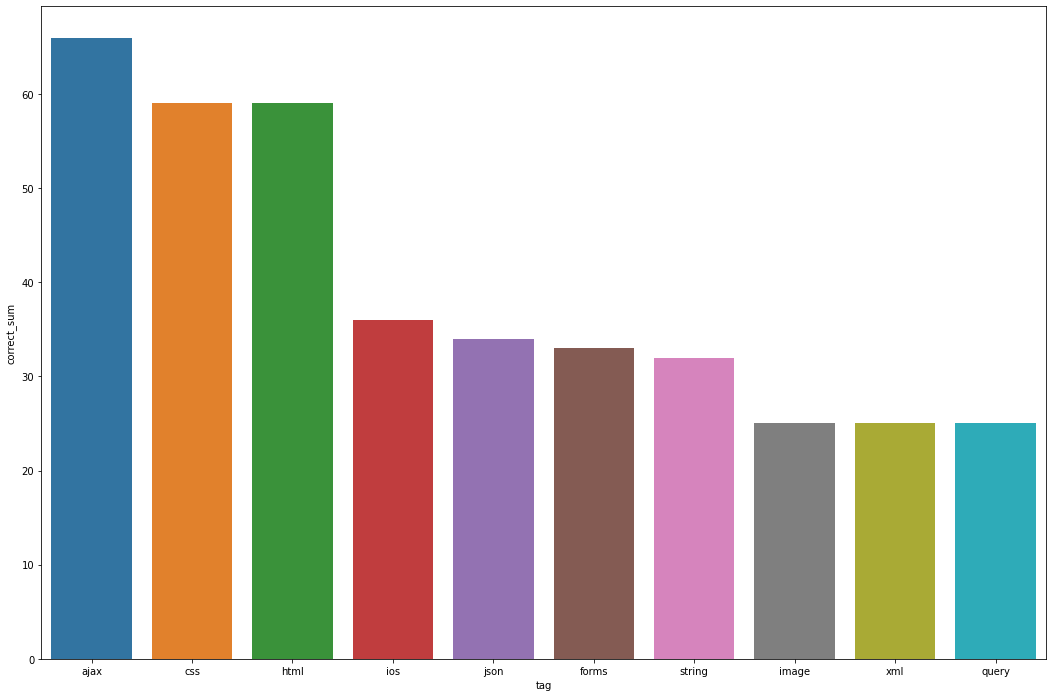

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="tag", y="correct_sum", data=top_10_correct, ax =ax)
fig.show()

<ipython-input-21-680f5017ddb2>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


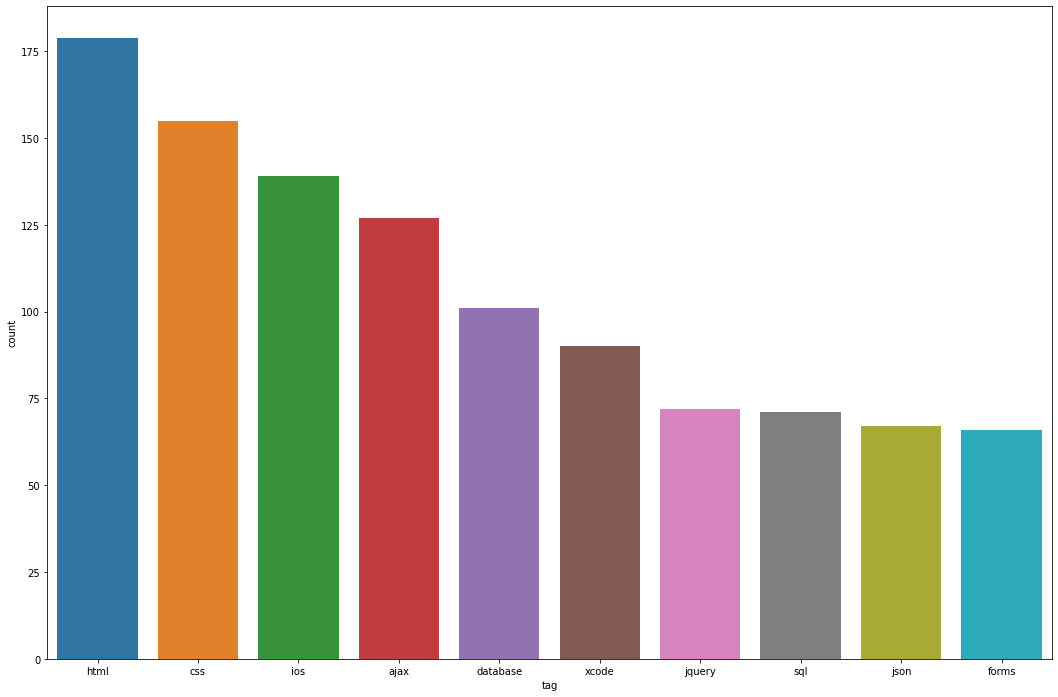

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="tag", y="count", data=top_10_count, ax =ax)
fig.show()

In [22]:
bottom_10_accuracy = correct_tags.orderBy("accuracy").limit(10).toPandas()
bottom_10_count = correct_tags.orderBy("count").limit(10).toPandas()
bottom_10_correct = correct_tags.orderBy("correct_sum").limit(10).toPandas()

In [23]:
display(bottom_10_accuracy)

,tag,correct_sum,count,accuracy
0,rss,0,13,0.0
1,qt,0,12,0.0
2,doctrine,0,14,0.0
3,jar,0,7,0.0
4,network-programming,0,9,0.0
5,map,0,15,0.0
6,charts,0,15,0.0
7,android-widget,0,9,0.0
8,keyboard,0,18,0.0
9,phpmyadmin,0,13,0.0


In [24]:
display(bottom_10_correct)

,tag,correct_sum,count,accuracy
0,rss,0,13,0.0
1,jar,0,7,0.0
2,network-programming,0,9,0.0
3,qt,0,12,0.0
4,doctrine,0,14,0.0
5,map,0,15,0.0
6,charts,0,15,0.0
7,android-widget,0,9,0.0
8,keyboard,0,18,0.0
9,phpmyadmin,0,13,0.0


In [25]:
display(bottom_10_count)

,tag,correct_sum,count,accuracy
0,uikit,0,3,0.000000
1,linker,1,3,0.333333
2,sed,0,4,0.000000
3,devise,0,5,0.000000
4,copy,1,5,0.200000
5,widget,3,6,0.500000
6,eclipse-plugin,0,6,0.000000
7,nginx,1,6,0.166667
8,header,1,6,0.166667
9,internationalization,0,6,0.000000
